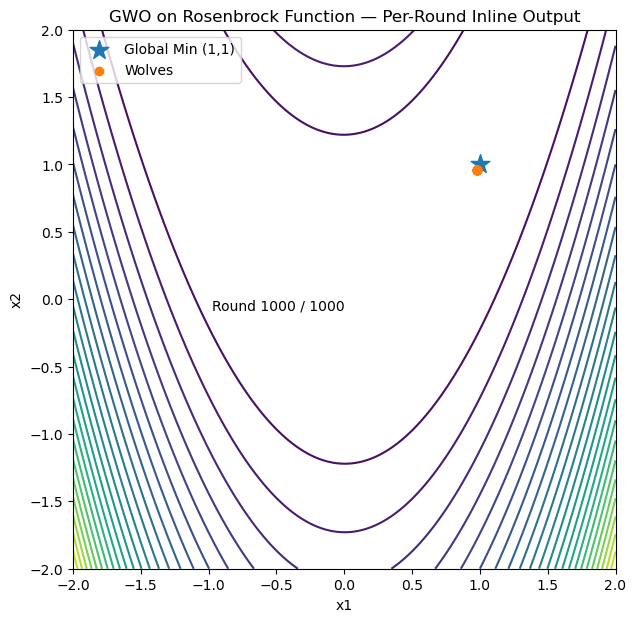

In [9]:
# Inline Rosenbrock (per the image) — updates one plot per round with ~1s delay
# No seaborn; single plot; default colors only.
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

# -------------------------------
# กำหนดค่าพื้นฐาน
n_rounds = 1000
n_wolves = 20
dim = 2
domain = [-2, 2]   # ตามภาพ: [-2,2] × [-2,2]

# ฟังก์ชัน Rosenbrock n-มิติ: sum_{i=1..d-1}[100(x_{i+1}-x_i^2)^2 + (1-x_i)^2]
def f(pos):
    x = np.asarray(pos)
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1.0 - x[:-1])**2)

# สุ่มตำแหน่งหมาป่า
rng = np.random.default_rng()
wolves = [rng.uniform(domain[0], domain[1], dim) for _ in range(n_wolves)]

# ประวัติตำแหน่งแต่ละรอบ
positions_history = []

for k in range(n_rounds):
    # จัดอันดับ (ค่าน้อยดีกว่า)
    sorted_idx = sorted(range(n_wolves), key=lambda i: f(wolves[i]))
    X_alpha, X_beta, X_delta = wolves[sorted_idx[0]], wolves[sorted_idx[1]], wolves[sorted_idx[2]]

    # เก็บตำแหน่งก่อนอัปเดตในรอบนี้
    positions_history.append(np.array(wolves))

    # อัปเดตหมาป่า
    for i in range(n_wolves):
        X = wolves[i]
        C1, C2, C3 = rng.uniform(0, 2, dim), rng.uniform(0, 2, dim), rng.uniform(0, 2, dim)
        lower, upper = -1 + k / n_rounds, 1 - k / n_rounds
        A1, A2, A3 = rng.uniform(lower, upper, dim), rng.uniform(lower, upper, dim), rng.uniform(lower, upper, dim)
        D_alpha = np.abs(C1 * X_alpha - X)
        D_beta  = np.abs(C2 * X_beta  - X)
        D_delta = np.abs(C3 * X_delta - X)
        X1 = X_alpha - A1 * D_alpha
        X2 = X_beta  - A2 * D_beta
        X3 = X_delta - A3 * D_delta
        X_new = (X1 + X2 + X3) / 3
        wolves[i] = np.clip(X_new, domain[0], domain[1])

# -------------------------------
# เตรียม Contour ของ Rosenbrock 2D (ใช้มิติ 0 และ 1 ในการวาด)
x = np.linspace(domain[0], domain[1], 400)
y = np.linspace(domain[0], domain[1], 400)
Xg, Yg = np.meshgrid(x, y)
Z = 100.0 * (Yg - Xg**2)**2 + (1.0 - Xg)**2

# -------------------------------
# แสดงผลแบบ "อัปเดตใน output เดียว" ทีละรอบ
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(domain[0], domain[1])
ax.set_ylim(domain[0], domain[1])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("GWO on Rosenbrock Function — Per-Round Inline Output")

# วาด contour คงที่ (ใช้ระดับไม่เยอะเพื่อมองเห็นจุด)
ax.contour(Xg, Yg, Z, levels=30)

# จุด global minimum ที่ (1,1)
ax.scatter([1], [1], marker='*', s=200, label='Global Min (1,1)')

# สร้าง scatter สำหรับหมาป่า (เฟรมแรก)
scat = ax.scatter(positions_history[0][:, 0], positions_history[0][:, 1], label="Wolves")

txt = ax.text(0.5, 0.5, f"Round 1 / {len(positions_history)}", transform=ax.transAxes,
              ha="right", va="top")
ax.legend(loc="upper left")

# วนแสดงรายรอบ
for t, pos in enumerate(positions_history, start=1):
    if t % 20 == 0:
        print(f"Round {t} / {len(positions_history)}")
        scat.set_offsets(pos[:, :2])
        txt.set_text(f"Round {t} / {len(positions_history)}")
        clear_output(wait=True)
        display(fig)
        plt.pause(0.001)  # ให้ matplotlib วาดเฟรม
        time.sleep(0.25)   # ดีเลย์ ~1 วินาที

plt.close(fig)


no animetion

In [12]:
import numpy as np

# -------------------------------
# พารามิเตอร์
n_rounds = 1000       # จำนวนรอบย่อยต่อชุด
extra_rounds = 10    # จำนวนชุด (ลูปใหญ่)
n_wolves = 20
dim = 2
domain = [-2, 2]
reset_each_set = False   # ถ้าอยากรีเซ็ตฝูงทุกชุด ให้ตั้งเป็น True

# -------------------------------
# ฟังก์ชัน Rosenbrock n-มิติ
def f(pos):
    x = np.asarray(pos)
    return np.sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1.0 - x[:-1])**2)

# -------------------------------
# สุ่มตำแหน่งหมาป่าเริ่มต้น
rng = np.random.default_rng(0)
wolves0 = [rng.uniform(domain[0], domain[1], dim) for _ in range(n_wolves)]
wolves = [w.copy() for w in wolves0]

# -------------------------------
# อัปเดต 1 รอบและคืนค่า f(best) หลังอัปเดต
def step(k, total_rounds):
    global wolves
    # จัดอันดับ alpha/beta/delta
    sorted_idx = sorted(range(n_wolves), key=lambda i: f(wolves[i]))
    X_alpha, X_beta, X_delta = (
        wolves[sorted_idx[0]],
        wolves[sorted_idx[1]],
        wolves[sorted_idx[2]],
    )

    # อัปเดตหมาป่าทั้งฝูง
    for i in range(n_wolves):
        X = wolves[i]
        C1, C2, C3 = (
            rng.uniform(0, 2, dim),
            rng.uniform(0, 2, dim),
            rng.uniform(0, 2, dim),
        )
        lower, upper = -1 + k / total_rounds, 1 - k / total_rounds
        A1, A2, A3 = (
            rng.uniform(lower, upper, dim),
            rng.uniform(lower, upper, dim),
            rng.uniform(lower, upper, dim),
        )

        D_alpha = np.abs(C1 * X_alpha - X)
        D_beta = np.abs(C2 * X_beta - X)
        D_delta = np.abs(C3 * X_delta - X)

        X1 = X_alpha - A1 * D_alpha
        X2 = X_beta - A2 * D_beta
        X3 = X_delta - A3 * D_delta

        X_new = (X1 + X2 + X3) / 3
        wolves[i] = np.clip(X_new, domain[0], domain[1])

    # คืนค่า best หลังอัปเดตรอบนี้
    best_idx = min(range(n_wolves), key=lambda i: f(wolves[i]))
    return f(wolves[best_idx])

# -------------------------------
# ลูปซ้อนลูป + คำนวณค่าเฉลี่ยของค่ารอบสุดท้ายที่ดีที่สุดในแต่ละชุด
final_bests_across_sets = []

for outer in range(extra_rounds):
    if reset_each_set:
        wolves = [w.copy() for w in wolves0]

    best_values = []
    for inner in range(n_rounds):
        best_values.append(step(inner, total_rounds=n_rounds))

    final_best = best_values[-1]   # ค่ารอบสุดท้ายของลูปย่อยในชุดนี้
    final_bests_across_sets.append(final_best)
    print(f"[ชุดที่ {outer+1}] f(best)_รอบสุดท้าย = {final_best:.6f}")

# -------------------------------
# ค่าเฉลี่ยของ “ค่ารอบสุดท้ายที่ดีที่สุด” ข้ามทุกชุด
avg_of_final_bests = float(np.mean(final_bests_across_sets))
print(f"\nค่าเฉลี่ยของ f(best)_รอบสุดท้าย ใน {extra_rounds} ชุด = {avg_of_final_bests:.6f}")


[ชุดที่ 1] f(best)_รอบสุดท้าย = 0.000425
[ชุดที่ 2] f(best)_รอบสุดท้าย = 0.000088
[ชุดที่ 3] f(best)_รอบสุดท้าย = 0.000000
[ชุดที่ 4] f(best)_รอบสุดท้าย = 0.000013
[ชุดที่ 5] f(best)_รอบสุดท้าย = 0.000049
[ชุดที่ 6] f(best)_รอบสุดท้าย = 0.000390
[ชุดที่ 7] f(best)_รอบสุดท้าย = 0.001066
[ชุดที่ 8] f(best)_รอบสุดท้าย = 0.000300
[ชุดที่ 9] f(best)_รอบสุดท้าย = 0.002492
[ชุดที่ 10] f(best)_รอบสุดท้าย = 0.000955

ค่าเฉลี่ยของ f(best)_รอบสุดท้าย ใน 10 ชุด = 0.000578
